In [1]:
import pandas as pd
import glob
import numpy as np
import glob
import math
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import pyreadr
import warnings
warnings.filterwarnings("ignore")

In [2]:
one_arm_files = glob.glob('/Users/zkarwowska/new_embl_folder/zeevi_dataset_v5/results/results_files/one_arm/*')
placebo_files = glob.glob('/Users/zkarwowska/new_embl_folder/zeevi_dataset_v5/results/results_files/placebo/*')

In [3]:
CROSS_SECTIONAL_CLR = pd.read_csv('/Users/zkarwowska/new_embl_folder/zeevi_dataset_v5/results/results_files/one_arm/baseline_clr_one_arm.csv', index_col = [0])
CROSS_SECTIONAL_LOG = pd.read_csv('/Users/zkarwowska/new_embl_folder/zeevi_dataset_v5/results/results_files/one_arm/baseline_log_one_arm.csv', index_col = [0])

In [4]:
CROSS_SECTIONAL_CLR = CROSS_SECTIONAL_CLR.rename({'auc':"ROC-AUC",
                                                  'precision':"Precision",
                                                  'recall':"Recall"}, axis=1)

CROSS_SECTIONAL_LOG = CROSS_SECTIONAL_LOG.rename({'auc':"ROC-AUC",
                                                  'precision':"Precision",
                                                  'recall':"Recall"}, axis=1)

In [5]:
CROSS_SECTIONAL_LOG['transformation'] = CROSS_SECTIONAL_LOG['transformation'].replace('relab', 'log_relab').replace('log', 'log_relab')
CROSS_SECTIONAL_LOG['model_name'] = CROSS_SECTIONAL_LOG.model + '.' + CROSS_SECTIONAL_LOG.transformation
CROSS_SECTIONAL_LOG['setup'] = 'baseline'

In [6]:
ONE_ARM_FILES = []
for file in one_arm_files:
    df = pd.read_csv(file, index_col = [0])
    ONE_ARM_FILES.append(df)


ONE_ARM_FILES_DF = pd.concat(ONE_ARM_FILES)
ONE_ARM_FILES_DF['transformation'] = ONE_ARM_FILES_DF['transformation'].replace(np.nan, '')
ONE_ARM_FILES_DF['transformation'] = ONE_ARM_FILES_DF['transformation'].replace('relab', 'log_relab').replace('log', 'log_relab')
ONE_ARM_FILES_DF['model_name'] = ONE_ARM_FILES_DF.model + '.' + ONE_ARM_FILES_DF.transformation
ONE_ARM_FILES_DF['setup'] = 'one_arm'

ONE_ARM_FILES_DF = ONE_ARM_FILES_DF.rename({'auc':"ROC-AUC",
                        'precision':"Precision",
                        'recall':"Recall"}, axis=1)

In [7]:
PLACEBO_FILES = []
for file in placebo_files:
    df = pd.read_csv(file, index_col = [0])
    PLACEBO_FILES.append(df)


PLACEBO_FILES_DF = pd.concat(PLACEBO_FILES)
PLACEBO_FILES_DF['transformation'] = PLACEBO_FILES_DF['transformation'].replace('none', '').replace('NONE', '').replace('log', 'log_relab')
PLACEBO_FILES_DF['transformation'] = PLACEBO_FILES_DF['transformation'].replace('relab', 'log_relab')
PLACEBO_FILES_DF['model_name'] = PLACEBO_FILES_DF.model + '.' + PLACEBO_FILES_DF.transformation
PLACEBO_FILES_DF['setup'] = 'placebo'

PLACEBO_FILES_DF = PLACEBO_FILES_DF.rename({'auc':"ROC-AUC",
                        'precision':"Precision",
                        'recall':"Recall"}, axis=1)

In [8]:
D1 = PLACEBO_FILES_DF[(PLACEBO_FILES_DF['sampling'] == 2) & (PLACEBO_FILES_DF['sample_size'] == 10)].reset_index(drop=True)
D2 = ONE_ARM_FILES_DF[(ONE_ARM_FILES_DF['sampling'] == 4) & (ONE_ARM_FILES_DF['sample_size'] == 10)].reset_index(drop=True)  
D3 = CROSS_SECTIONAL_LOG[CROSS_SECTIONAL_LOG['sample_size'] == 20].reset_index(drop=True)  

combined_df = pd.concat([D1, D2, D3], axis=0).reset_index(drop=True)
combined_df['total_N'] = 40

D4 = PLACEBO_FILES_DF[(PLACEBO_FILES_DF['sampling'] == 2) & (PLACEBO_FILES_DF['sample_size'] == 20)].reset_index(drop=True)
D5 = ONE_ARM_FILES_DF[(ONE_ARM_FILES_DF['sampling'] == 4) & (ONE_ARM_FILES_DF['sample_size'] == 20)].reset_index(drop=True)
D6 = CROSS_SECTIONAL_LOG[CROSS_SECTIONAL_LOG['sample_size'] == 40].reset_index(drop=True)  

combined_df1 = pd.concat([D4, D5, D6], axis=0).reset_index(drop=True)
combined_df1['total_N'] = 80

DF = pd.concat([combined_df, combined_df1], axis=0)

effect_size = 15
DF = DF[DF['effect_size'] == effect_size]

In [9]:
DF.model_name.unique()

array(['nbmm.', 'wilcoxon.log_relab', 'maaslin.clr', 'nbzimm.',
       'maaslin.log_relab', 'spliner.log_relab', 'spliner.clr', 'zigmm.',
       'wilcoxon.clr', 'linda.', 'metasplines.none', 'baseline.log_relab'],
      dtype=object)

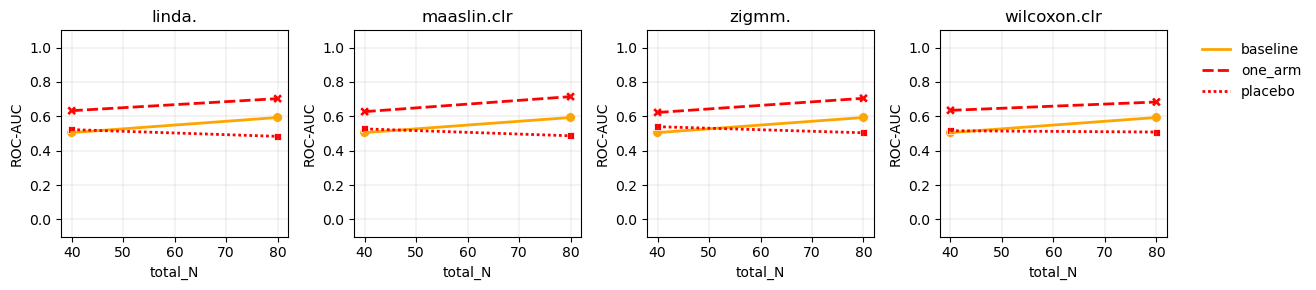

In [10]:
def plot_model(model, ax, legend):

    df = DF[DF['model_name'].isin([model, 'baseline.log_relab'])]
    df['hue'] = np.where(df.model_name == model, 'longitudinal', 'cross-secrional')
    df = df.groupby(by = ['setup', 'hue', 'total_N'])['ROC-AUC'].mean().reset_index()

    color_dict = {'baseline':'orange', 'one_arm':'red', 'placebo':'red', model:'red'}
    
    sns.lineplot(df, 
                 x = 'total_N', 
                 y = 'ROC-AUC', 
                 style = 'setup', 
                 hue = 'setup',
                 lw=2,
                 palette = color_dict,
                 ax=axes[ax], 
                 legend=legend)
    
    sns.scatterplot(df, 
                    x = 'total_N', 
                    y = 'ROC-AUC', 
                    style = 'setup', 
                    hue = 'setup',
                    palette = color_dict,
                    s=50,
                    ax=axes[ax], 
                    legend=False)
    
    axes[ax].set_ylim([-0.1, 1.1])
    axes[ax].title.set_text(model)
    axes[ax].grid(lw=.2)

fig, axes = plt.subplots(1, 4, figsize = (12, 3))

plot_model('linda.', 0, False)
plot_model('maaslin.clr', 1, False)
plot_model('zigmm.', 2, False)
plot_model('wilcoxon.clr', 3, True)

axes[3].legend(bbox_to_anchor = (1.1, 1), edgecolor='w')
plt.tight_layout()
#plt.savefig('/Users/zkarwowska/Desktop/EMBL_project/zeevi_dataset_v5/placebo_recall.png', dpi=300)

In [11]:
DF.to_csv(f'zeevi_dataset_v5/one_arm_scripts/placebo_figure_input_efs{effect_size}.csv')